<h1> Traveling in College Park </h1>
<h4> By Raphael Katz </h4>
<br>

<font size="3"> I have, as of now, spent 3 full school years in College Park. During this time I've learned quite a lot in school, but I also think I've learned a lot of street smarts. Namely, I've learned that the streets in College Park are not very smart. It seems like every intersection has nonsensical traffic patterns. Many intersections have left-turn signals that I have scarcely, if ever, seen used, while cars intending to drive straight have to wait and begin backing-up to the previous light. Traffic lights or stop signs are placed at pedestrian crossings that are hardly ever utilized. Cars are required to stop for pedestrians in a crosswalk regardless of posted signs, so these extra lights and signs just serves to slow traffic when there aren't pedistrians. Not to mention, there must be anywhere between 6-10 construction projects ongoing on Baltimore Ave on any given week. <br>
Anyways, that's enough ranting. I wanted to analyze student travel experiences within the city, particularly for students who walk, bike, or drive in and around campus, since I suspect that these traffic patterns could lead to travel by bike being faster than driving.

<font size="3"> To conduct this analysis, I'll need some data regarding traveling within the city. Luckily for me, Google saves everything that we say and do. If you'd like to follow along, here's the steps you need to get this data for yourself from Google. (If you're an Apple sheep, you can instead spend some time considering why you chose to use an inferior product) 
   <ol>
       <li> Go to [timeline.google.com](https://www.google.com/maps/timeline?gl=JP). This is where you'll access your Google location history </li>
       <li> Click the settings icon on the bottom right of the screen. Then tap "Download a copy of all your data" </li>
       <li> Deselect all, and then scroll down to "Location History" and check its checkbox. </li>
       <li> Hit "next step" then "create export" (change the maximum file size if you have too much data to download at once) </li>
    </ol>
After following these steps, Google will email you a link to download this location data. It will be formatted as a .zip file which will contain each month of your location history as a JSON file that I will show you how to use below.

<h3> Part 1: Data Collection </h3>

Since the data is stored in JSON we'll need to import the json library. We'll use datetime to calculate trip durations and store our time-based data in a more accessible format. And pandas and numpy will be useful for us as well

In [1]:
import json
import datetime as dt
import pandas as pd
import numpy as np

#Turn off warnings since I keep getting false positive on the settingWithCopyWarning when I'm not even using chained-assignment
import warnings
warnings.filterwarnings('ignore')

Before I get started on real data collection, I want to provide the code I used to combine all of my JSON files that I collected together. This had to be done since Google Maps provides each month of timeline data as its own JSON file, and I have lived in College Park for over 30 months. I found it was easier to combine all the JSON files together beforehand rather than read each one one at a time. This way, I only have to save one file of JSON instead of 30 per timeline. Plus, this gives me a way to separate my own timeline data into one file, and any other person's timeline data into a separate file that I'll combine into a dataframe later

In [3]:
# create a list of all filenames using loops cuz I am lazy
months = ["JANUARY","FEBRUARY","MARCH","APRIL","MAY","JUNE","JULY","AUGUST","SEPTEMBER","OCTOBER","NOVEMBER","DECEMBER"]
years = ["2019_","2020_","2021_","2022_"]
fileList = []
for year in years:
    for month in months:
        fileList.append(f"{year}{month}"+".json")
# get rid of the extra files that account for months that are pre-August 2019, and post-May 2022
fileList = fileList[7:41]

# define a function to merge these files - Found online at: https://stackoverflow.com/questions/57422734/how-to-merge-multiple-json-files-into-one-file-in-python
def merge_JsonFiles(filenames, outputName):
    result = list()
    for f1 in filenames:
        with open(f1, 'r') as infile:
            result.append(json.load(infile))
    
    with open(outputName, 'w') as output_file:
        json.dump(result, output_file)

# run this above function - This takes a few seconds to run on my PC. This must be done for each user's timeline that was downloaded
# ensure that all files to be combined are stored at the top-level in the same folder as this notebook, so that they will be locatable

# UNCOMMENT THE LINE BELOW TO MERGE JSON
#merge_JsonFiles(fileList, "southCampus.JSON")

Now, I have data stored in JSON files ready to be imported. However, there are a few more preliminary things I need to get in order. Since these files contain all timeline data from Google, they will have many trips that don't take place in College Park. Therefore, I started by finding the latitude and longitude boundaries of campus and the surrounding areas in College Park (basically from the apartments off of South Campus up north to College Park Woods. And then far East enough to reach my home, and encompassing campus in the West). <br> Using Google Maps I found that this area stretches over latitudes: 38.977086 to 39.011410 and it stretches over longitudes: -76.925135 to -76.955097. Since I plan to calculate travel times only in the campus area, I want to use only travel segments that start and end within these latitude and longitude ranges. We'll have to pick out these ranges for lat/long data from our JSON data that was downloaded from Google. <br>

Next I took a look at the JSON files to get an idea of what data they contained and how they were organized. I used a JSON tree plugin for Notepad++, but Jupyter Notebook offers its own JSON visualizer as well. <br> The top level of JSON is a single object named "timelineObjects." This contains an array of all the data collected by Google as a sequence of numbers. Each of these objects can be either a "placeVisit" or an "activitySegment." These two are basically interwoven with each other since each placeVisit is a location that a user ended a trip in, and each activitySegment represents a trip traveled by a user. <br>
<h4> activitySegment elements </h4>
activitySegment has: startLocation, endLocation, duration, distance (in meters), activityType, confidence, activities, waypointPath, and simplifiedRawPath. Most of these are self-explanatory, but the remainder are actually simple as well. activity is the method of transportation (cycling, in_passenger_vehicle, train, etc.), confidence is how confident Google is that this method of transportation predicted is correct (can be HIGH, MEDIUM, etc.). activities contains the list of possible activities and the probability that Google thinks you were conducting this specific activity (essentially a further breakdown of 'activity'). waypointPath is the lat/long coordinates of each waypoint google has marked along your journey. simplifiedRawPath seems to be just waypointPath with less waypoints, but I'm not entirely sure what it represents. It likely is used for Google to display trips visually on your timeline without flooding the screen with too many waypoints. <br>
<h4> placeVisit elements </h4>
placeVisit has elements: location, duration, placeConfidence, childVisits, visitConfidence, otherCandidateLocations, placeVisitType, and a few others. These are mostly self explanatory as well. placeConfidence is how likely Google thinks that the location given is correct (I assume this is done since GPS isn't hyper-accurate, so they try to predict exact location). childVisits is more local locations that may have been visited (like individual shops within a mall). placeVisitType is a value like SINGLE_PLACE. <br> <br>
Many of these attributes for activitySegment will be useful like startLocation, endLocation, duration, distance, acitvityType, and confidence. For placeVisit, I don't expect to need this data, however, it may turn out to be useful for determining which activitySegments ended on campus by checking if the placeVisit Location is a building on campus or campus itself.
<hr>

<font size="3"> Now we can actually organize our data into a dataframe. I created a list of all timeline JSON files I combined, and then looped through each of these combining them into a dataframe while keeping track of which timeline they came from. 

In [4]:
# create a list of all different combined timelines I currently have
fileList = ["northCampus.JSON", "southCampus.JSON"]

# Create a dataframe, and then append each file's data onto it by looping through them
timelineData = pd.DataFrame()
# Remember the last index added from each JSON file so that we can use it to keep track of which user each set of data came from
userIndices = []

for file in fileList:
    # Load the data in with loads() to be ready to convert to a dataframe
    with open(file,'r') as f:
        data_temp = json.loads(f.read())
    # Then use pd.json_normalize to flatten the data since it was in nested JSON object
    # record_path tells it where to look at data to normalize
    df_temp = pd.json_normalize(data_temp, record_path = ['timelineObjects'])
    timelineData = pd.concat([timelineData, df_temp], ignore_index = True)
    # Save the last index that this user's data was stored at
    userIndices.append(len(timelineData.index))

# Add a new column to store the data of which user each datapoint came from
timelineData['user'] = np.nan
# Cycle through the indices of user's data we stored in the dataframe, and update the 'user' column with the correct user based on the filename it came from
lastIndex = 0
for idx, userIndex in enumerate(userIndices):
    timelineData['user'][lastIndex:userIndex] = fileList[idx][:-5 or None]
    lastIndex = userIndex

timelineData

,activitySegment.startLocation.latitudeE7,activitySegment.startLocation.longitudeE7,activitySegment.startLocation.sourceInfo.deviceTag,activitySegment.endLocation.latitudeE7,activitySegment.endLocation.longitudeE7,activitySegment.endLocation.sourceInfo.deviceTag,activitySegment.duration.startTimestamp,activitySegment.duration.endTimestamp,activitySegment.distance,activitySegment.activityType,...,activitySegment.parkingEvent.location.sourceInfo.deviceTag,activitySegment.editConfirmationStatus,activitySegment.lastEditedTimestamp,activitySegment.editActionMetadata.activitySegment.activityType,activitySegment.editActionMetadata.activitySegment.activityConfidence,activitySegment.editActionMetadata.editHistory.editEvent,activitySegment.transitPath.stopTimesInfo,activitySegment.startLocation.semanticType,activitySegment.endLocation.isCurrentLocation,user
0,409055734.0,-740184674.0,-1.951075e+09,411579275.0,-740794651.0,-1.951075e+09,2019-08-01T02:07:55.374Z,2019-08-01T02:40:28.486Z,32480.0,IN_PASSENGER_VEHICLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,northCampus
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,northCampus
2,411579275.0,-740794651.0,-1.951075e+09,410441704.0,-740664597.0,-1.951075e+09,2019-08-01T12:26:34.532Z,2019-08-01T12:54:31.018Z,14412.0,IN_PASSENGER_VEHICLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,northCampus
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,northCampus
4,410441704.0,-740664597.0,-1.951075e+09,411579275.0,-740794651.0,-1.951075e+09,2019-08-01T14:00:39.657Z,2019-08-01T14:24:01.362Z,13425.0,IN_PASSENGER_VEHICLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,northCampus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,southCampus
15290,389957141.0,-769315174.0,1.063545e+09,389903154.0,-769333382.0,1.063545e+09,2022-05-08T18:05:49Z,2022-05-08T18:07:33Z,665.0,IN_PASSENGER_VEHICLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,southCampus
15291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,southCampus
15292,389904756.0,-769329603.0,1.063545e+09,389810793.0,-769401450.0,1.063545e+09,2022-05-08T18:24:32.883Z,2022-05-08T18:30:40.718Z,1215.0,IN_PASSENGER_VEHICLE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,southCampus


<h3> Part 2: Data Processing </h3>

<font size="3"> This data obviously needs a lot of clean-up. There are many useless columns, and I don't currently want any placeVisit data so half of the rows need to be removed too. I saw some libraries like Glom that could've been used to extract this data from JSON more nicely, but since I only need a few attributes it's simple enough to just clean up the data after putting it in the dataframe. <br>
The first step is to drop all rows with NaN in a column that contains data for activitySegments (this will get rid of all placeVisit data). Then we can delete all columns with data we don't need, and rename them to more intuitive names

In [5]:
# Start by dropping all of the placeVisits by getting rid of rows that don't have data in activitySegment columns
timelineData.dropna(subset=['activitySegment.startLocation.latitudeE7'],inplace=True)

# Next include only the columns we actually care about
timelineDataClean = timelineData[timelineData.columns[[0,1,3,4,6,7,8,9,10,93]]]

# Finally let's rename these columns
timelineDataClean.set_axis(['startLat', 'startLng', 'endLat', 'endLng', 'startTime', 'endTime', 'dist', 'activity', 'confidence', 'user'], axis=1, inplace=True)
timelineDataClean

,startLat,startLng,endLat,endLng,startTime,endTime,dist,activity,confidence,user
0,409055734.0,-740184674.0,411579275.0,-740794651.0,2019-08-01T02:07:55.374Z,2019-08-01T02:40:28.486Z,32480.0,IN_PASSENGER_VEHICLE,HIGH,northCampus
2,411579275.0,-740794651.0,410441704.0,-740664597.0,2019-08-01T12:26:34.532Z,2019-08-01T12:54:31.018Z,14412.0,IN_PASSENGER_VEHICLE,HIGH,northCampus
4,410441704.0,-740664597.0,411579275.0,-740794651.0,2019-08-01T14:00:39.657Z,2019-08-01T14:24:01.362Z,13425.0,IN_PASSENGER_VEHICLE,HIGH,northCampus
6,411579275.0,-740794651.0,410441704.0,-740664597.0,2019-08-02T13:24:23.363Z,2019-08-02T13:52:16.803Z,14006.0,IN_PASSENGER_VEHICLE,HIGH,northCampus
8,410441704.0,-740664597.0,411579275.0,-740794651.0,2019-08-02T15:06:32.845Z,2019-08-02T15:30:32.931Z,13848.0,IN_PASSENGER_VEHICLE,HIGH,northCampus
...,...,...,...,...,...,...,...,...,...,...
15284,389813142.0,-769408174.0,389878493.0,-769447149.0,2022-05-07T22:48:10Z,2022-05-07T23:01:25.297Z,812.0,WALKING,HIGH,southCampus
15286,389874134.0,-769445473.0,389814610.0,-769408181.0,2022-05-08T02:54:25.129Z,2022-05-08T03:04:01.089Z,736.0,WALKING,MEDIUM,southCampus
15288,389810670.0,-769401759.0,389960820.0,-769318377.0,2022-05-08T17:34:03.693Z,2022-05-08T17:44:05Z,2489.0,IN_PASSENGER_VEHICLE,HIGH,southCampus
15290,389957141.0,-769315174.0,389903154.0,-769333382.0,2022-05-08T18:05:49Z,2022-05-08T18:07:33Z,665.0,IN_PASSENGER_VEHICLE,HIGH,southCampus


<font size="3"> That's more like it! We can now easily see all the data we have. With our data cleaned up, we can start filtering it to ensure that we're only including data that takes place around the UMD campus. In addition I'm going to drop any LOW confidence activities since Google doesn't display these in my account's timeline history and they may not represent the true activity that took place. I don't believe that dropping these datapoints should skew the data since I expect the low confidence is due to bad GPS data, not due to any factors I plan to analyze such as duration or distance (so it represents MCAR data for my purposes). 

In [6]:
# First let's ensure we only look at start and end locations that are on the campus
# This means filtering by latitudes between 38.977086 to 39.011410 (or 39.000676 to exclude CP Woods) and longitudes between -76.925135 to -76.955097 (or -76.953067 to exclude CP Woods)
# These coordinates are represented without a decimal point though, so in reality we need to multiply these numbers by 10^7

# Doesn't include College Park Woods
#criterian = (timelineDataClean['startLat'] < 390000676) & (timelineDataClean['startLat'] > 389770860)
#criterian = criterian & (timelineDataClean['endLat'] < 390000676) & (timelineDataClean['endLat'] > 389770860)
#criterian = criterian & (timelineDataClean['startLng'] < -769251350) & (timelineDataClean['startLng'] > -769530670)
#criterian = criterian & (timelineDataClean['endLng'] < -769251350) & (timelineDataClean['endLng'] > -769530670)
# Includes College Park Woods
criterian = (timelineDataClean['startLat'] < 390114100) & (timelineDataClean['startLat'] > 389770860)
criterian = criterian & (timelineDataClean['endLat'] < 390114100) & (timelineDataClean['endLat'] > 389770860)
criterian = criterian & (timelineDataClean['startLng'] < -769251350) & (timelineDataClean['startLng'] > -769550970)
criterian = criterian & (timelineDataClean['endLng'] < -769251350) & (timelineDataClean['endLng'] > -769550970)

# We also only want activitySegments where the confidence level is at least MEDIUM
criterian = criterian & ( (timelineDataClean['confidence'] == "MEDIUM") | (timelineDataClean['confidence'] == "HIGH") )

finalData = timelineDataClean[criterian] #only keep data that met all of the above criteria
finalData

,startLat,startLng,endLat,endLng,startTime,endTime,dist,activity,confidence,user
179,389886162.0,-769407629.0,389827510.0,-769486330.0,2019-08-22T14:47:36Z,2019-08-22T14:54:04Z,1411.0,CYCLING,HIGH,northCampus
183,389915426.0,-769472858.0,389827510.0,-769486330.0,2019-08-22T16:00:27Z,2019-08-22T16:08:33Z,1766.0,CYCLING,HIGH,northCampus
185,389827510.0,-769486330.0,389869183.0,-769425543.0,2019-08-22T16:24:47.363Z,2019-08-22T16:28:46.112Z,843.0,WALKING,HIGH,northCampus
187,389821113.0,-769456484.0,389825567.0,-769367840.0,2019-08-22T16:35:58.161Z,2019-08-22T16:47:04.594Z,1913.0,IN_PASSENGER_VEHICLE,MEDIUM,northCampus
192,389869183.0,-769425543.0,389827510.0,-769486330.0,2019-08-22T17:40:43.893Z,2019-08-22T17:41:36.598Z,737.0,WALKING,MEDIUM,northCampus
...,...,...,...,...,...,...,...,...,...,...
15284,389813142.0,-769408174.0,389878493.0,-769447149.0,2022-05-07T22:48:10Z,2022-05-07T23:01:25.297Z,812.0,WALKING,HIGH,southCampus
15286,389874134.0,-769445473.0,389814610.0,-769408181.0,2022-05-08T02:54:25.129Z,2022-05-08T03:04:01.089Z,736.0,WALKING,MEDIUM,southCampus
15288,389810670.0,-769401759.0,389960820.0,-769318377.0,2022-05-08T17:34:03.693Z,2022-05-08T17:44:05Z,2489.0,IN_PASSENGER_VEHICLE,HIGH,southCampus
15290,389957141.0,-769315174.0,389903154.0,-769333382.0,2022-05-08T18:05:49Z,2022-05-08T18:07:33Z,665.0,IN_PASSENGER_VEHICLE,HIGH,southCampus


<font size="3">  Next we've got to convert our startTime and endTime into a "duration" column in the dataframe. To do this we'll first have to clean up our startTime and endTime columns so that they are actual Datetime objects that we can calculate a difference between. We'll do this by string slicing to extract the individual parts of the date and time, then recombine them into a datetime object using pd.to_datetime(). Once we've got the datetimes, the library allows us to simply subtract them to create a timeDelta object that tells us how much time has passed between them. I'll then just convert this timeDelta into some number of seconds for ease of use.

In [7]:
# First assemble all the data into a new dataframe that we'll need to create the datetime object from startTime
startDateTimeAttributes = pd.DataFrame()
startDateTimeAttributes['year'] = finalData['startTime'].str[0:4]
startDateTimeAttributes['month'] = finalData['startTime'].str[5:7]
startDateTimeAttributes['day'] = finalData['startTime'].str[8:10]
startDateTimeAttributes['hour'] = finalData['startTime'].str[11:13]
startDateTimeAttributes['minute'] = finalData['startTime'].str[14:16]
startDateTimeAttributes['second'] = finalData['startTime'].str[17:19]
# Then use this handy-dandy function that automatically converts a dataframe in this format into a datetime series
finalData['startDateTime'] = pd.to_datetime(startDateTimeAttributes)
# Then do this same process for endTime
endDateTimeAttributes = pd.DataFrame()
endDateTimeAttributes['year'] = finalData['endTime'].str[0:4]
endDateTimeAttributes['month'] = finalData['endTime'].str[5:7]
endDateTimeAttributes['day'] = finalData['endTime'].str[8:10]
endDateTimeAttributes['hour'] = finalData['endTime'].str[11:13]
endDateTimeAttributes['minute'] = finalData['endTime'].str[14:16]
endDateTimeAttributes['second'] = finalData['endTime'].str[17:19]
finalData['endDateTime'] = pd.to_datetime(endDateTimeAttributes)

# Now let's create the duration as a timeDelta
finalData['duration'] = (finalData['endDateTime']-finalData['startDateTime'])
finalData['duration'] = finalData['duration'].apply(lambda x : x.seconds)
finalData

,startLat,startLng,endLat,endLng,startTime,endTime,dist,activity,confidence,user,startDateTime,endDateTime,duration
179,389886162.0,-769407629.0,389827510.0,-769486330.0,2019-08-22T14:47:36Z,2019-08-22T14:54:04Z,1411.0,CYCLING,HIGH,northCampus,2019-08-22 14:47:36,2019-08-22 14:54:04,388
183,389915426.0,-769472858.0,389827510.0,-769486330.0,2019-08-22T16:00:27Z,2019-08-22T16:08:33Z,1766.0,CYCLING,HIGH,northCampus,2019-08-22 16:00:27,2019-08-22 16:08:33,486
185,389827510.0,-769486330.0,389869183.0,-769425543.0,2019-08-22T16:24:47.363Z,2019-08-22T16:28:46.112Z,843.0,WALKING,HIGH,northCampus,2019-08-22 16:24:47,2019-08-22 16:28:46,239
187,389821113.0,-769456484.0,389825567.0,-769367840.0,2019-08-22T16:35:58.161Z,2019-08-22T16:47:04.594Z,1913.0,IN_PASSENGER_VEHICLE,MEDIUM,northCampus,2019-08-22 16:35:58,2019-08-22 16:47:04,666
192,389869183.0,-769425543.0,389827510.0,-769486330.0,2019-08-22T17:40:43.893Z,2019-08-22T17:41:36.598Z,737.0,WALKING,MEDIUM,northCampus,2019-08-22 17:40:43,2019-08-22 17:41:36,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15284,389813142.0,-769408174.0,389878493.0,-769447149.0,2022-05-07T22:48:10Z,2022-05-07T23:01:25.297Z,812.0,WALKING,HIGH,southCampus,2022-05-07 22:48:10,2022-05-07 23:01:25,795
15286,389874134.0,-769445473.0,389814610.0,-769408181.0,2022-05-08T02:54:25.129Z,2022-05-08T03:04:01.089Z,736.0,WALKING,MEDIUM,southCampus,2022-05-08 02:54:25,2022-05-08 03:04:01,576
15288,389810670.0,-769401759.0,389960820.0,-769318377.0,2022-05-08T17:34:03.693Z,2022-05-08T17:44:05Z,2489.0,IN_PASSENGER_VEHICLE,HIGH,southCampus,2022-05-08 17:34:03,2022-05-08 17:44:05,602
15290,389957141.0,-769315174.0,389903154.0,-769333382.0,2022-05-08T18:05:49Z,2022-05-08T18:07:33Z,665.0,IN_PASSENGER_VEHICLE,HIGH,southCampus,2022-05-08 18:05:49,2022-05-08 18:07:33,104


<font size="3"> Now that we've got the number of meters traveled, as well as the number of seconds spent traveling, we can calculate our speed in m/s. So let's divide the distance column by the duration column to get this quantity

In [8]:
finalData['speed'] = finalData['dist']/finalData['duration']
finalData

,startLat,startLng,endLat,endLng,startTime,endTime,dist,activity,confidence,user,startDateTime,endDateTime,duration,speed
179,389886162.0,-769407629.0,389827510.0,-769486330.0,2019-08-22T14:47:36Z,2019-08-22T14:54:04Z,1411.0,CYCLING,HIGH,northCampus,2019-08-22 14:47:36,2019-08-22 14:54:04,388,3.636598
183,389915426.0,-769472858.0,389827510.0,-769486330.0,2019-08-22T16:00:27Z,2019-08-22T16:08:33Z,1766.0,CYCLING,HIGH,northCampus,2019-08-22 16:00:27,2019-08-22 16:08:33,486,3.633745
185,389827510.0,-769486330.0,389869183.0,-769425543.0,2019-08-22T16:24:47.363Z,2019-08-22T16:28:46.112Z,843.0,WALKING,HIGH,northCampus,2019-08-22 16:24:47,2019-08-22 16:28:46,239,3.527197
187,389821113.0,-769456484.0,389825567.0,-769367840.0,2019-08-22T16:35:58.161Z,2019-08-22T16:47:04.594Z,1913.0,IN_PASSENGER_VEHICLE,MEDIUM,northCampus,2019-08-22 16:35:58,2019-08-22 16:47:04,666,2.872372
192,389869183.0,-769425543.0,389827510.0,-769486330.0,2019-08-22T17:40:43.893Z,2019-08-22T17:41:36.598Z,737.0,WALKING,MEDIUM,northCampus,2019-08-22 17:40:43,2019-08-22 17:41:36,53,13.905660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15284,389813142.0,-769408174.0,389878493.0,-769447149.0,2022-05-07T22:48:10Z,2022-05-07T23:01:25.297Z,812.0,WALKING,HIGH,southCampus,2022-05-07 22:48:10,2022-05-07 23:01:25,795,1.021384
15286,389874134.0,-769445473.0,389814610.0,-769408181.0,2022-05-08T02:54:25.129Z,2022-05-08T03:04:01.089Z,736.0,WALKING,MEDIUM,southCampus,2022-05-08 02:54:25,2022-05-08 03:04:01,576,1.277778
15288,389810670.0,-769401759.0,389960820.0,-769318377.0,2022-05-08T17:34:03.693Z,2022-05-08T17:44:05Z,2489.0,IN_PASSENGER_VEHICLE,HIGH,southCampus,2022-05-08 17:34:03,2022-05-08 17:44:05,602,4.134551
15290,389957141.0,-769315174.0,389903154.0,-769333382.0,2022-05-08T18:05:49Z,2022-05-08T18:07:33Z,665.0,IN_PASSENGER_VEHICLE,HIGH,southCampus,2022-05-08 18:05:49,2022-05-08 18:07:33,104,6.394231


<h3> Part 3: Exploratory Data Analysis </h3>

<font size="3"> We now have everything prepared in a good format to begin doing some exploratory data analysis. Let's create some graphs to see if there appear to be any clustering or correlations in our data. First let's look at a scatter plot where we plot the distance vs duration for each form of transportation to get an idea of if there seems to be a consistent speed between each form of transportation. We can also see if maybe the distance has any effect on the speed for each of these methods of transportation as well

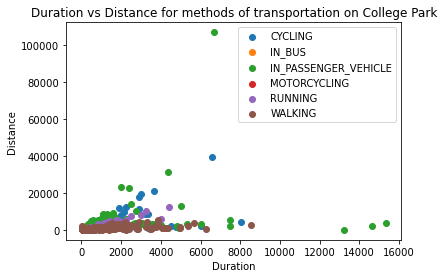

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for key, grp in finalData.groupby(['activity']):
    plt.scatter(grp['duration'], grp['dist'], label = key)
ax.set_title("Duration vs Distance for methods of transportation on College Park")
ax.set_ylabel("Distance")
ax.set_xlabel("Duration");
plt.legend(loc='best')

<font size="3"> Looks like we've discovered a few interesting things here. For one, I only expected to see 3 forms of transportation: cycling, in_passenger_vehicle, and walking. However, I have taken a bus a couple times and gone on a scooter once or twice as well, so these are showing up in the data. So we've definitely learned about the cyclical nature of the data science pipeline because now it's time to do more data processing and clean-up. Since there are so few data points for bussing and motorcycling, I'll remove them and re-try this analysis. There also appears to be a couple outliers that probably represent bad location data from Google, so we should probably remove these points that represent impossibly fast travel. We can find these by sorting our data from fastest travel to slowest and looking at these points on my Google timeline to decide if they are legitimate trips.

In [10]:
# find which points should be removed by investigating these in the Google timeline to see if they represent true trips
for key, grp in finalData.groupby(['activity']):
    print(grp.sort_values(by=['speed'], ascending = False)[['activity','startDateTime','speed','duration','dist']])

      activity       startDateTime      speed  duration    dist
8025   CYCLING 2019-08-29 12:25:15  13.140625        64   841.0
8571   CYCLING 2019-10-18 12:29:23  12.548387        31   389.0
8441   CYCLING 2019-10-06 15:54:45  12.533333        30   376.0
8336   CYCLING 2019-09-24 18:11:27  12.103448        58   702.0
497    CYCLING 2019-10-29 17:51:18  11.890411        73   868.0
...        ...                 ...        ...       ...     ...
9183   CYCLING 2019-12-11 13:31:51   0.437705       610   267.0
13417  CYCLING 2021-10-03 23:33:08   0.389564      4772  1859.0
5193   CYCLING 2021-09-04 19:41:17   0.322446      6001  1935.0
6843   CYCLING 2022-01-31 19:31:37   0.300119      3362  1009.0
5829   CYCLING 2021-10-18 18:37:22   0.283448      2773   786.0

[1034 rows x 5 columns]
     activity       startDateTime     speed  duration    dist
891    IN_BUS 2019-12-14 04:12:08  3.076923       507  1560.0
747    IN_BUS 2019-11-24 02:11:41  2.905710       753  2188.0
1299   IN_BUS 2020-02

<font size="3">
    
* So we have to remove two motorcycling trips since they have too few datapoints for meaningful anaylsis. 
* The two fastest cycling speeds are the only suspect cycling data points with speeds over 11m/s (~20 mph). On further inspection these both represented times when I was going from my dorm (Hagerstown) directly downhill just a few minutes before class starts. So the more likely explanation is that I was careening down stadium drive on campus to race to get to my class on time. 
* There are also the 4 data points from times I rode the bus, but I threw away all of these since there's too few of these for meaningful analysis as well.
* Next, I must consider the times I was driving that seem like outliers. There's only 1 of these where my speed was about 16m/s (over 35 mph) for over 100 km (over 60 miles) which at first glance sounds like an impossibility given the traffic situation in College Park. Upon inspection the trip actually represents me getting on the highway, driving to Baltimore, and returning to College Park, which shouldn't be included in analysis. I hadn't considered the possibility of leaving College Park during any trip and returning counting as one trip, but I can actually ensure I don't include any other trips like this by checking that the distance isn't too high like this trip's distance is. I can get rid of driving trips that are too long in duration as well. Any trip within College Park should be less than maybe 10 km. So I'll remove all points that meet this criteria as well. 
* There are the walking activities to consider, and there are a lot of outliers here from trips with durations that are too short. I can fix this by getting rid of all trips under 85 seconds since these are the ones that seem to produce unreasonable speeds. There also somehow existed one single nan in the "walking" activities, so this gets removed too. 
* Finally, there is the running column to consider. There are very few points here and their speeds are comparable to walking speeds so I'm just going to combine these together as a single column representing movement on foot. 
* We end up removing about 100 points total by considering these above outliers

In [11]:
# Remove all outliers
outliers = (finalData['activity'] == "MOTORCYCLING") | (finalData['activity'] == "IN_BUS")  #get rid of bus and motorcycle trips entirely
outliers = outliers | ((finalData['duration'] < 85) & (finalData['activity'] == "WALKING")) #get rid of walking trips that are too short 
outliers = outliers | (finalData['dist'] > 10000)                                           #get rid of trips that obviously are too long to be within CP
outliers = outliers | ((finalData['duration'] > 3000) & (finalData['activity'] == "IN_PASSENGER_VEHICLE")) #get rid of trips that are too long (timewise) to be driving trips in CP
finalerData = finalData.drop(finalData[outliers].index)

# Remove NaN
finalerData.dropna(subset=['speed'],inplace = True)

# Combine running column with walking column
finalerData.loc[finalerData['activity'] == "RUNNING",'activity'] = "WALKING"

# Repeat the above analysis to make sure our data looks good now
for key, grp in finalerData.groupby(['activity']):
    print(grp.sort_values(by=['speed'], ascending = False)[['activity','startDateTime','speed','duration','dist']])
print(finalerData['activity'].size)
print(finalData['activity'].size)

      activity       startDateTime      speed  duration    dist
8025   CYCLING 2019-08-29 12:25:15  13.140625        64   841.0
8571   CYCLING 2019-10-18 12:29:23  12.548387        31   389.0
8441   CYCLING 2019-10-06 15:54:45  12.533333        30   376.0
8336   CYCLING 2019-09-24 18:11:27  12.103448        58   702.0
497    CYCLING 2019-10-29 17:51:18  11.890411        73   868.0
...        ...                 ...        ...       ...     ...
9183   CYCLING 2019-12-11 13:31:51   0.437705       610   267.0
13417  CYCLING 2021-10-03 23:33:08   0.389564      4772  1859.0
5193   CYCLING 2021-09-04 19:41:17   0.322446      6001  1935.0
6843   CYCLING 2022-01-31 19:31:37   0.300119      3362  1009.0
5829   CYCLING 2021-10-18 18:37:22   0.283448      2773   786.0

[1027 rows x 5 columns]
                   activity       startDateTime     speed  duration    dist
12364  IN_PASSENGER_VEHICLE 2021-04-25 01:52:55  9.766046       483  4717.0
13264  IN_PASSENGER_VEHICLE 2021-09-03 17:43:22  9.5794

<font size="3"> Our data is looking really good now so let's repeat this graph now with this new data. A line of best-fit for each graph might be informative as well. I think interesting trends to consider would be duration vs distance, distance vs speed, and duration vs speed.

Text(0.5, 0, 'Duration (s)')

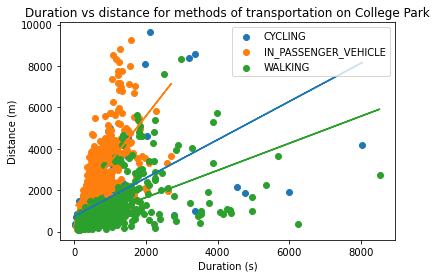

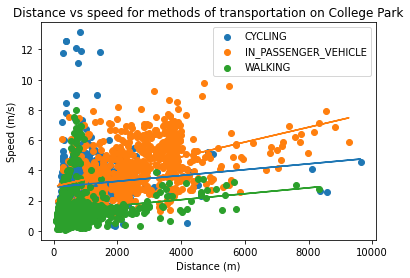

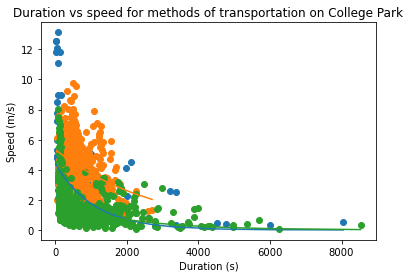

In [12]:
# We'll need scipy to do an exponential curve fit:
import scipy.optimize

fig, ax = plt.subplots()
for key, grp in finalerData.groupby(['activity']):
    plt.scatter(grp['duration'], grp['dist'], label = key) #scatter plot
    # calculate and plot best fit
    theta = np.polyfit(grp['duration'],grp['dist'],1)
    bestFit = theta[1] + theta[0] * np.array(grp['duration'])
    ax.plot(grp['duration'],bestFit);
ax.set_title("Duration vs distance for methods of transportation on College Park")
ax.set_ylabel("Distance (m)")
ax.set_xlabel("Duration (s)")
plt.legend(loc='best')

fig, ax = plt.subplots()
for key, grp in finalerData.groupby(['activity']):
    plt.scatter(grp['dist'], grp['speed'], label = key)
    # calculate and plot best fit
    theta = np.polyfit(grp['dist'],grp['speed'],1)
    bestFit = theta[1] + theta[0] * np.array(grp['dist'])
    ax.plot(grp['dist'],bestFit);
ax.set_title("Distance vs speed for methods of transportation on College Park")
ax.set_ylabel("Speed (m/s)")
ax.set_xlabel("Distance (m)")
plt.legend(loc='best')

fig, ax = plt.subplots()
for key, grp in finalerData.groupby(['activity']):
    plt.scatter(grp['duration'], grp['speed'], label = key)
    # calculate and plot best fit
    # The best fit for this graph appears exponential so here's code I found to fit that curve: https://stackoverflow.com/questions/3433486/how-to-do-exponential-and-logarithmic-curve-fitting-in-python-i-found-only-poly
    # It's neccessary to sort the data so that it is plotted correctly
    grp.sort_values(by=['duration'],inplace=True)
    popt, pcov = scipy.optimize.curve_fit(lambda t,a,b,c: a*np.exp(b*(t-c)), grp['duration'],grp['speed'], p0=(5,-.1,-5))
    bestFit = popt[0]*np.exp(popt[1] * (np.array(grp['duration']) - popt[2]))
    ax.plot(grp['duration'],bestFit);
ax.set_title("Duration vs speed for methods of transportation on College Park")
ax.set_ylabel("Speed (m/s)")
ax.set_xlabel("Duration (s)")

<font size="3"> It also could be interesting to see if there are any differences in typical speeds between the two users I have data for. I have lived on or near North Campus for 3 years and my friend who I collected the other timeline from has lived on or near South Campus for 3 years. Let's make a graph of duration vs distance (i.e. average speed) for each form of transportation and see if they appear the same for a user who has lived on/off North Campus for 3 years for one who has lived on/off South Campus for 3 years

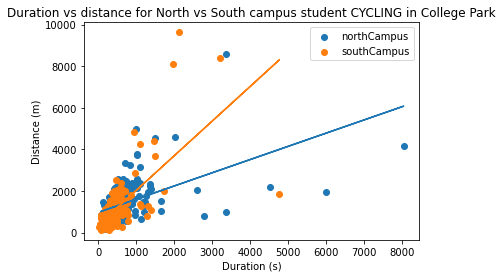

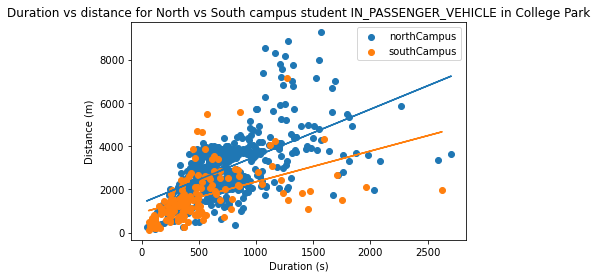

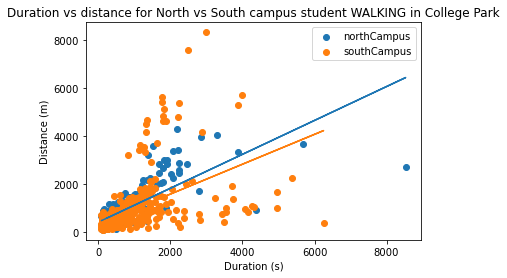

In [13]:
for key, grp in finalerData.groupby(['activity']): #one graph for each activity
    fig, ax = plt.subplots()
    for key2, grp2 in grp.groupby(['user']): #separate users in each graph
        plt.scatter(grp2['duration'], grp2['dist'], label = key2)
        # calculate and plot best fit
        theta = np.polyfit(grp2['duration'],grp2['dist'],1)
        bestFit = theta[1] + theta[0] * np.array(grp2['duration'])
        ax.plot(grp2['duration'],bestFit);
    ax.set_title(f"Duration vs distance for North vs South campus student {key} in College Park")
    ax.set_ylabel("Distance (m)")
    ax.set_xlabel("Duration (s)")
    plt.legend(loc='best')


<font size="3"> One last trend that might be interesting is to see if time of day has any influence on speeds. We can try plotting time of day vs speed for each form of transportation to look into this

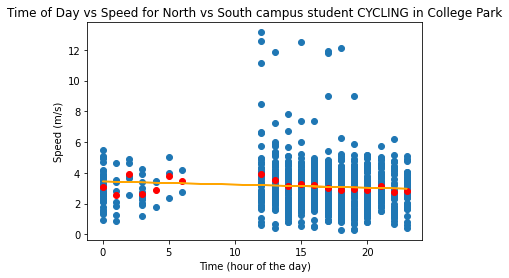

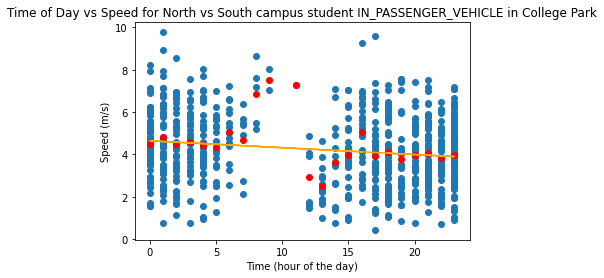

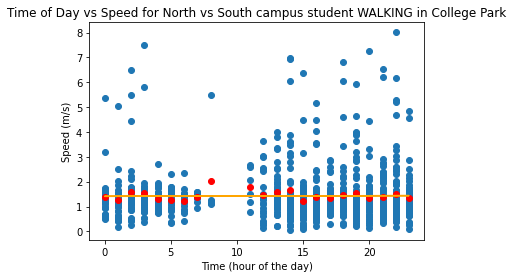

In [14]:
for key, grp in finalerData.groupby(['activity']): #one graph for each activity
    fig, ax = plt.subplots()
    plt.scatter(grp['startDateTime'].apply(lambda x : x.hour), grp['speed'], label = key)
    # calculate average speed for each hour of the day
    # First create a dataframe that has the hours and speeds instead of the whole datetimes
    hours = grp['startDateTime'].apply(lambda x : x.hour).rename('hour')
    hours = pd.concat([hours, grp['speed']], axis = 1)
    # Then create a dictionary of hour to average speed
    avgs = hours.groupby(['hour']).mean()['speed']
    # Scatter these averages too
    plt.scatter(avgs.index, avgs, color = 'red')
    # And let's see a best fit line too
    theta = np.polyfit(grp['startDateTime'].apply(lambda x : x.hour),grp['speed'],1)
    bestFit = theta[1] + theta[0] * np.array(grp['startDateTime'].apply(lambda x : x.hour))
    ax.plot(grp['startDateTime'].apply(lambda x : x.hour),bestFit, color='orange');
    ax.set_title(f"Time of Day vs Speed for North vs South campus student {key} in College Park")
    ax.set_ylabel("Speed (m/s)")
    ax.set_xlabel("Time (hour of the day)")

<h3> Duration/Distance/Speed Graphs </h3>
<font size="3"> These first graphs are probably the more interesting ones to consider. The duration vs distance graph is notable since it seems to follow a negative exponential. This means very short trips of all types are very fast, then as they get a bit faster, they quickly level off to a slower speed. Then stay relatively constant as duration increases. <br> The graph of distance vs duration shows off the average speeds of each form of transportation in the slopes of their lines (dist/time). In this graph we see that driving appears fastest, followed by cycling, and ending with walking. <br> The other graph (distance vs speed) also has notable trends. We can see that as distance increases the speed of the trip tends to increase as well. So longer trips tend to have faster speeds for all forms, but this is most pronounced for driving. <br>
<font size="2">    <h3> North vs South campus user graphs </h3>
<font size="3">In these 3 graph we see that my friend and I walk and drive generally the same speeds as seen by the slopes of these second set of graphs. However, I have unfortunately forced myself to come to terms with the fact that he bikes way faster than me. <br>
<font size="2">    <h3> Time of day graphs </h3>
<font size="3">These graphs are a bit suprising to me. I didn't expect there to be a downward trend on speed as hours go on in the day, but this does seem to occur for both driving and cycling. This could be due to being more tired while cycling and less rushed while driving possibly. Some traffic lights also run on different cycles at night which could cause slower movement possibly (since they facilitate more time for pedestrians to cross). There also looks to be more variance in nighttime hours for walking and afternoon hours for cycling. I'm not entirely sure what the reasons for this could be. However there is much more variance all around for driving, which is likely due to the nature of lights and random traffic which sometimes allow for quick drives and sometimes slow drivers down. These factors cause less disturbance when cycling and walking

<h3> Part 4: Hypothesis Testing </h3>

<font size="3"> Now that we've gotten some ideas of what factors influence travel times and how they interact, it would be good to create a model that could predict travel times given certain inputs. I want the model to give a prediction of what the average speed for the trip will be given the distance that the user wants to travel. The relationship between these variables appears linear, so this is the model I will match to. I think it would also be helpful to add interaction variables to this model for what form of transportation is being taken. <br>
Without the interaction variables, our linear model would have the form y = $\beta$<sub>0</sub> + $\beta$<sub>1</sub>$\times$distance. And we'd use our data to find the coefficients that minimize our error. However, for each interaction variable we'll need two more coefficients so that our final equation will be: y = $\beta$<sub>0</sub> + $\beta$<sub>1</sub>$\times$distance + $\beta$<sub>2</sub>$\times$isDriving + $\beta$<sub>3</sub>$\times$distance$\times$isDriving + $\beta$<sub>4</sub>$\times$isWalking + $\beta$<sub>5</sub>$\times$distance$\times$isWalking. This requires us to add two dummy variables to represent walking and driving as modes of transportation. If both dummy variables are zero, this will represent cycling. 

In [15]:
# We need to create dummy columns for the mode of transportation interaction variable
# We use drop_first to avoid the 'dummy variable trap'
activity_feature = pd.get_dummies(finalerData.activity, drop_first=True)
# Separate out our standard feature that we want to create the model on
standard_feature = finalerData[['dist','speed']]
# Combine the dummy variables into our data, so we can create the full model with the interaction variable
combined_feature = pd.concat([standard_feature,activity_feature], axis=1)
# Either we have a 1 in the WALKING column which represents walking trips, a 1 in the IN_PASSENGER_VEHICLE, which represents driving trips, or 0s in both which represents cycling

# This allows us to calculate beta0, beta1, beta2, and beta4. But we still need to have distance*activity, so we must add two more columns.
activities = finalerData.activity.values
for s in filter(lambda s: s != 'CYCLING', activities):
    combined_feature['dist*'+s] = combined_feature[s]*combined_feature['dist']
combined_feature

,dist,speed,IN_PASSENGER_VEHICLE,WALKING,dist*WALKING,dist*IN_PASSENGER_VEHICLE
179,1411.0,3.636598,0,0,0.0,0.0
183,1766.0,3.633745,0,0,0.0,0.0
185,843.0,3.527197,0,1,843.0,0.0
187,1913.0,2.872372,1,0,0.0,1913.0
194,1075.0,4.249012,0,0,0.0,0.0
...,...,...,...,...,...,...
15284,812.0,1.021384,0,1,812.0,0.0
15286,736.0,1.277778,0,1,736.0,0.0
15288,2489.0,4.134551,1,0,0.0,2489.0
15290,665.0,6.394231,1,0,0.0,665.0


<font size="3"> With our interaction variables set, our model is ready to be trained using a Linear Regression. So let's fit a linear regression to our data and see what coefficients we get.

In [16]:
from sklearn.linear_model import LinearRegression
# Generate X data and Y data
X = combined_feature.drop('speed', axis=1)
y  = combined_feature['speed']

lr = LinearRegression()
lr.fit(X,y)
print(f"beta0 = {lr.intercept_}, beta1-beta5 = {lr.coef_}")

beta0 = 2.889592431356135, beta1-beta5 = [ 1.92843061e-04  3.17601018e-02 -1.61830754e+00  3.91315725e-06
  2.98819393e-04]


<font size="3"> But are these variables significant in predicting the final results? We can find out by using a statistics library. We want a p-value of less than .05 for a variable to be considered statistically significant. What this represents is that, there is only a 5% chance or less that we'd see this result in our data if our values weren't significant. Therefore, with a p-value of under .05 we'd feel comfortable accepting that these variables are significant in predicting the speed. So let's do some statistics and find out.

In [18]:
import statsmodels.api as sm
X = np.array(combined_feature.drop(['speed'], axis=1))
y = np.array(combined_feature['speed'])
X2 = sm.add_constant(X)
reg = sm.OLS(y,X2)
model = reg.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     476.5
Date:                Sun, 15 May 2022   Prob (F-statistic):               0.00
Time:                        17:20:06   Log-Likelihood:                -4714.8
No. Observations:                2815   AIC:                             9442.
Df Residuals:                    2809   BIC:                             9477.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8896      0.072     40.249      0.0

<font size="3"> There's a lot of data to unpack here, but the important parts that we care about are contained in the column in the middle section labaled "P>|t|". This represents our p-values for each interaction variable. Since $\beta$<sub>0</sub>, $\beta$<sub>1</sub>, $\beta$<sub>3</sub> and $\beta$<sub>5</sub> all have p values of 0 this means that they are virtually certain to be influencing our speed. $\beta$<sub>2</sub> and $\beta$<sub>4</sub>, however, are not statistically significant. $\beta$<sub>2</sub> affects the y-intercept for driving and $\beta$<sub>4</sub> affects the slope for walking. This seems to be consistent with our earlier graphs. Driving has the same y-intercept as cycling so a new variable to control this won't be statistically significant. Also, the slope for walking vs cycling in our earlier graphs look nearly identical, so it also isn't surprising that the variable that affects walking slope would be significant. Since the rest of the coefficients are statistically significant, though, that means we should keep them when modeling predictions. <br>
With that in mind, let's create a graph of expected speed for given distances for our model and each form of transportation

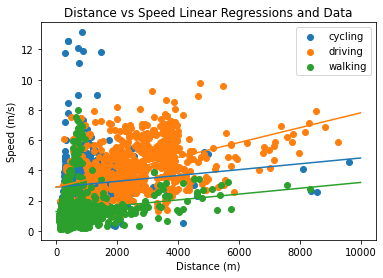

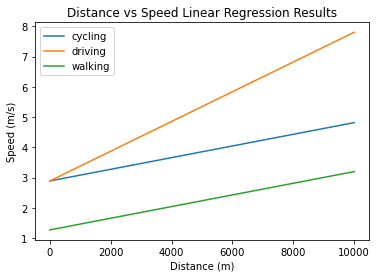

In [22]:
# We'll perform our prediction over [0,10000] and do a prediction for each form of transportation
# x1 is always multiplied by 'dist'. x2 and x4 are not significant so we won't use them
# x3 is multiplied by 1 to calculate walking prediction. x5 is multiplied by 'dist' to get driving prediction. For cycling, we don't use either
ind_cycling = pd.DataFrame({'dist' : range(0,10000), 'IN_PASSENGER_VEHICLE' : [0]*10000, 'WALKING' : [0]*10000, 'dist*WALKING' : [0]*10000, 'dist*IN_PASSENGER_VEHICLE' : [0]*10000})
ind_driving = pd.DataFrame({'dist' : range(0,10000), 'IN_PASSENGER_VEHICLE' : [0]*10000, 'WALKING' : [0]*10000, 'dist*WALKING' : [0]*10000, 'dist*IN_PASSENGER_VEHICLE' : range(0,10000)})
ind_walking = pd.DataFrame({'dist' : range(0,10000), 'IN_PASSENGER_VEHICLE' : [0]*10000, 'WALKING' : [1]*10000, 'dist*WALKING' : [0]*10000, 'dist*IN_PASSENGER_VEHICLE' : [0]*10000})

# Let's plot each of these
dep_cycling = lr.predict(ind_cycling)
dep_driving = lr.predict(ind_driving)
dep_walking = lr.predict(ind_walking)

# Plot linear regressions with scatter data
fig, ax = plt.subplots()
ax.plot(ind_cycling['dist'], dep_cycling)
ax.scatter(finalerData[finalerData['activity'] == "CYCLING"]['dist'], finalerData[finalerData['activity'] == "CYCLING"]['speed'], label = "cycling")
ax.plot(ind_driving['dist'], dep_driving)
ax.scatter(finalerData[finalerData['activity'] == "IN_PASSENGER_VEHICLE"]['dist'], finalerData[finalerData['activity'] == "IN_PASSENGER_VEHICLE"]['speed'], label = "driving")
ax.plot(ind_walking['dist'], dep_walking)
ax.scatter(finalerData[finalerData['activity'] == "WALKING"]['dist'], finalerData[finalerData['activity'] == "WALKING"]['speed'], label = "walking")
ax.set_title("Distance vs Speed Linear Regressions and Data")
ax.set_ylabel("Speed (m/s)")
ax.set_xlabel("Distance (m)")
plt.legend(loc='best')

# Plot linear regressions without scatter data
fig, ax = plt.subplots()
ax.plot(ind_cycling['dist'], dep_cycling, label = "cycling")
ax.plot(ind_driving['dist'], dep_driving, label = "driving")
ax.plot(ind_walking['dist'], dep_walking, label = "walking")
ax.set_title("Distance vs Speed Linear Regression Results")
ax.set_ylabel("Speed (m/s)")
ax.set_xlabel("Distance (m)")
plt.legend(loc='best');

<h3> Part 5: Interpretation of Data </h3>

<font size="3"> This project has some relatively interesting conclusions that could be used to help guide decisions about what form of transportation a student should take in a given scenario. However, these conclusions could also be useful for guiding policy decisions in College Park. <br> 
In the most direct sense, a student could use this model to predict how long a trip will take given a distance and mode of transportation. However, in the reverse, a student could decide what mode of transportation to take given a comparison in speed for the distance being traveled. For example, if a student wanted to bike from STAMP down to Iribe, this would represent a cycling trip of .5 miles. However, due to construction, in a car you must divert on a path that is .8 miles. Using the model a student could decide which of these trips is more worthwhile. <br>
More importantly, however, College Park could use this data to guide decisions in their city planning. Using knowledge of the speeds of different forms of transportation could help inform where the city should be placing bike lanes and it could also possibly be used to decide where they city might want to restrict cars or allow pedestrians. <br>
With a sufficiently large dataset comprised of many more students, insights could be given hyper-locally to instruct policy choices on a per-road basis. If certain streets seemed to be more conducive to bikers, it might be useful to install traffic signals for bikes. If certain streets are slow for cars, but quick for pedestrians, this model could help inform decisions about the length or frequency of pedestrian signals.

In [23]:
# Example of the above STAMP to Irebe example
print(f"Avg speed when cycling .5 miles: {lr.predict([[.5,0,0,0,0]])} m/s")
print(f"Avg speed when driving .8 miles: {lr.predict([[.8,0,0,0,.8]])} m/s")
print(f"STAMP to Iribe travel time by bicycle: {.5 / (lr.predict([[.5,0,0,0,0]])/26.822) } vs time by car: {.8 / (lr.predict([[.8,0,0,0,.8]])/26.822)}")
print("Biking is 2-3 min faster than driving for this distance")

Avg speed when cycling .5 miles: [2.88968885] m/s
Avg speed when driving .8 miles: [2.88998576] m/s
STAMP to Iribe travel time by bicycle: [4.64098409] vs time by car: [7.42481167]
Biking is 2-3 min faster than driving for this distance


***
<font size="3"> Just for fun here's a widget you can play around with to get an idea of what speed a given trip will be, and how long it will take it that speed

In [25]:
# Below I'll include some widgets to see various outputs for a given input
from ipywidgets import interact
print("Input mode of travel and distance in miles")
@interact(Travel = ['Biking','Driving','Walking'], distance = (0.01,6,.01))
def cycle_speed(Travel, distance):
    if (Travel == "Biking"):
        print(f"Average speed: {lr.predict([[distance*1609,0,0,0,0]])[0]*2.237:.2f} mph")
        print(f"Traveling {distance} miles by bike will take {distance * 60/(lr.predict([[distance*1609,0,0,0,0]])[0]*2.237):.2f} minutes")        
    elif (Travel == 'Driving'):
        print(f"Average speed: {lr.predict([[distance*1609,0,0,0,distance*1609]])[0]*2.237:.2f} mph")
        print(f"Traveling {distance} miles by car will take {distance * 60/(lr.predict([[distance*1609,0,0,0,distance*1609]])[0]*2.237):.2f} minutes")
    else:
        print(f"Average speed: {lr.predict([[distance*1609,0,1,0,0]])[0]*2.237:.2f} mph")
        print(f"Traveling {distance} miles by foot will take: {distance * 60/(lr.predict([[distance*1609,0,1,0,0]])[0]*2.237):.2f} min")

Input mode of travel and distance in miles


interactive(children=(Dropdown(description='Travel', options=('Biking', 'Driving', 'Walking'), value='Biking')…